# Expana -- assignment interview

## Create a presentation where you describe the characteristics of this time series and explain how you expect it to evolve until the end of 2023.

In this assignment, I analyzed the time series, identified potential patterns, and aimed to build a model capable of performing well on unseen data and reliably predicting the time series development for 2023. Specifically:

1. In the first part, I analyzed the time series. Due to the difficulty in determining the appropriate order for the ARIMA model and the lack of meaningful insights from the ACF and PACF plots, I adjusted the frequency of the time series to a monthly interval and attempted to forecast future values using a SARIMA model. Unfortunately, the results were unsatisfactory, and the predicted values had a different frequency than the original series. I've also attempted to forecast the test set using an ARIMA model. However, the correlation and partial correlation plots provided unclear insights, making it difficult to determine an optimal order for the model that could effectively capture price fluctuations in the test set. Additionally, the predictions using monthly frequency data yielded unsatisfactory results. Due to these challenges, I opted to proceed with a classical machine learning approach instead.

2. In the second part, I shifted to using supervised machine learning techniques to build a model. I implemented feature engineering (detailed below) and experimented with a set of variables to enhance prediction accuracy. Based on the patterns identified in the analysis and the results obtained, the machine learning model emerged as the most suitable approach for forecasting the time series in 2023. However, there is still potential for further improvements.

### 1. Loading the libraries and the data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

color_pale = sns.color_palette()
plt.style.use('seaborn-v0_8')

Analysis of the Time Series Plot:

- Clear Upward Trend: The most dominant feature is a strong upward trend in the 'Price' over time. This trend is present throughout the entire series, although its slope might vary slightly over different periods.

- Possible Cyclical/Seasonal Fluctuations:  Overlaid on the upward trend, we can observe what appear to be cyclical or seasonal fluctuations. These fluctuations are not strictly periodic but suggest recurring patterns of rises and falls in the 'Price' around the overall trend.

- Volatility Changes:  The fluctuations seem to increase in magnitude (volatility) as the 'Price' rises. This suggests that the variance of the series might not be constant over time (heteroscedasticity)

<Axes: title={'center': 'Exapana time series'}, xlabel='Date'>

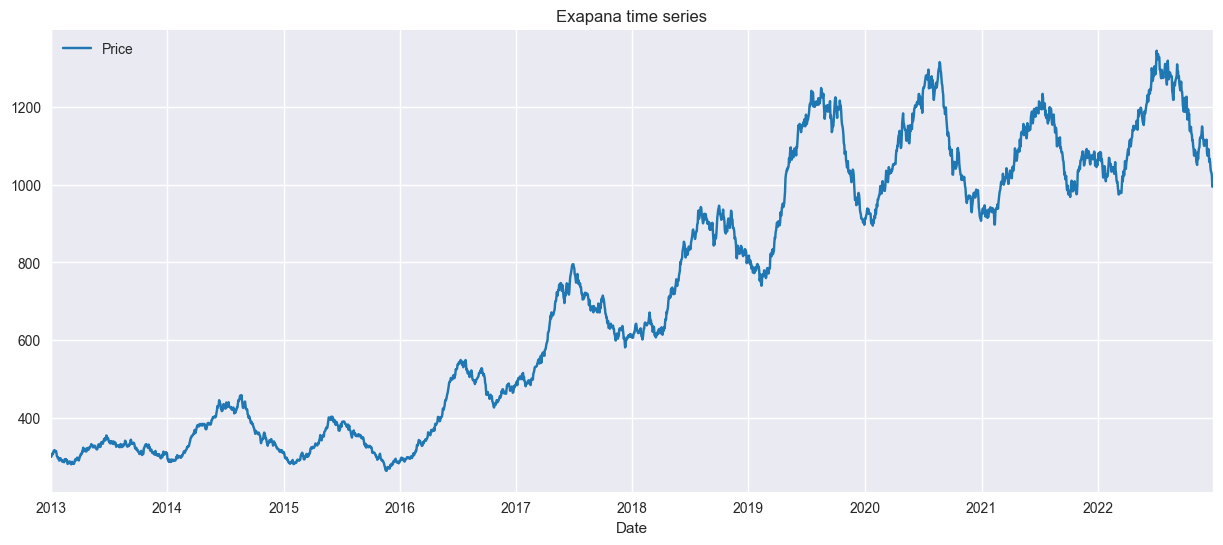

In [2]:
df = pd.read_excel("quantitative_analyst_case_Feb_2025.xlsx")
# date format: timstamp YYYY-mm-dd
df = df.set_index("Date")
df.plot(figsize=(15, 6), color = color_pale[0], title= "Exapana time series")

In [3]:
#Fill the values for the missing date (weekends by keeping the most recent value)
df = df.resample(rule = 'd').mean().ffill().asfreq('D')


### 1.1 Time series components
To gain a clearer understanding and visualize the components mentioned above, I'll apply seasonal decomposition to validate our hypothesis. As shown in the image below, the series exhibits an upward trend along with a seasonal pattern, with peaks occurring annually. I used the multiplicative seasonal decomposition model rather than the additive one, as the fluctuations are not constant over time, indicating varying levels of variance throughout the period.

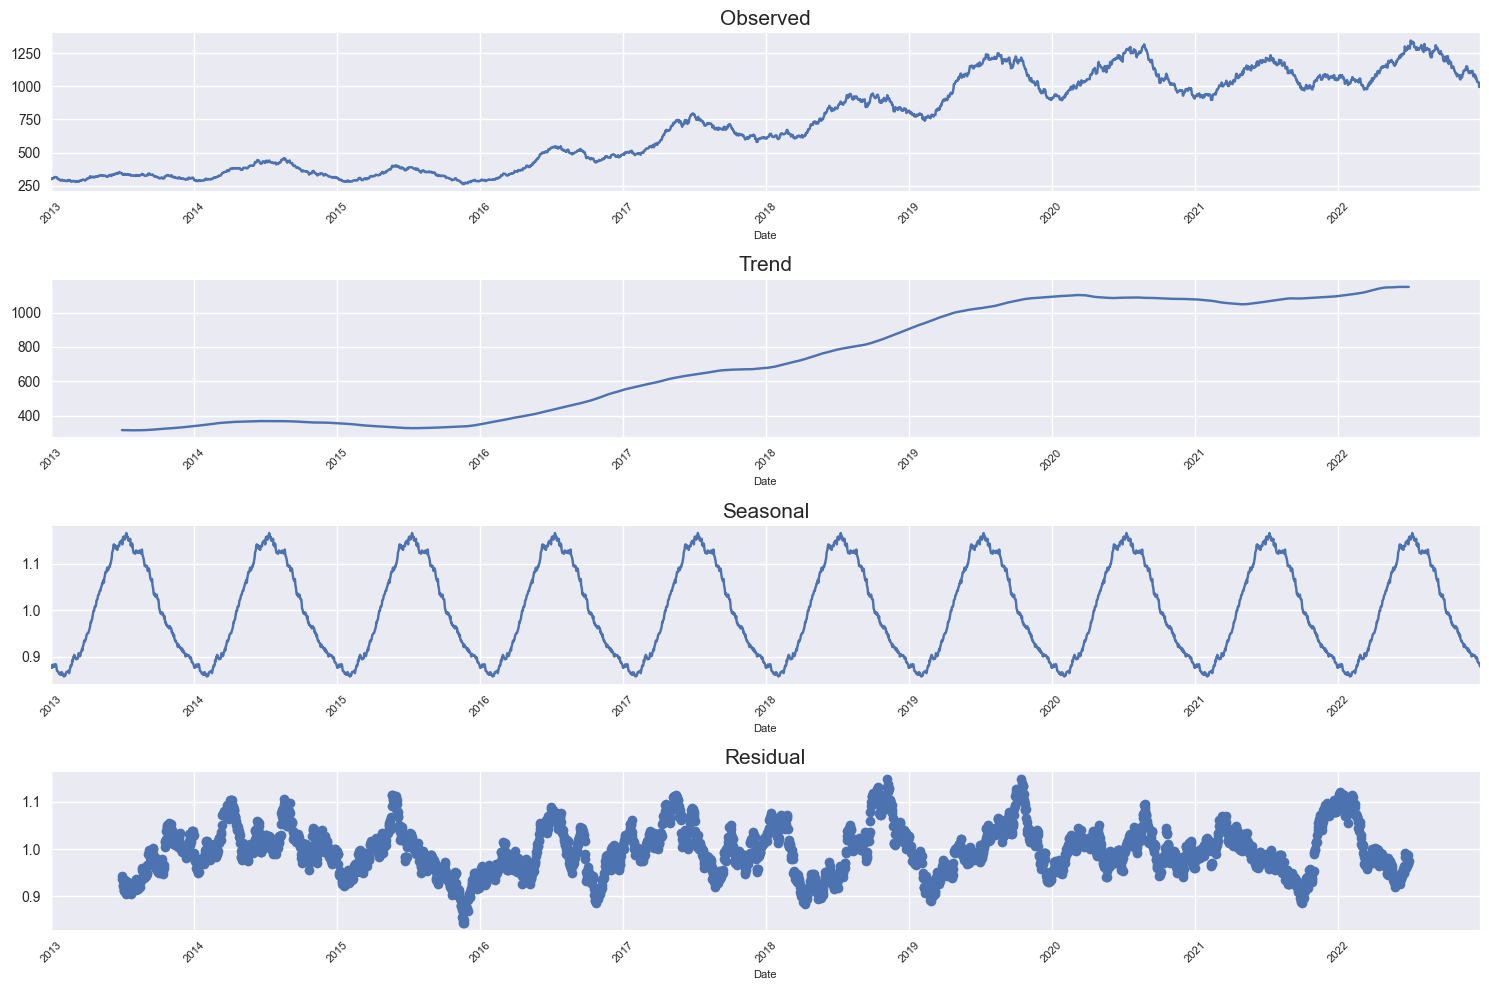

In [4]:
#no data for weekends etc. price from last non-null date is used to fill the data
decomposition_plot_multi = seasonal_decompose(df["Price"], model='multiplicative', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))  # Adjust figsize for width and height

decomposition_plot_multi.observed.plot(ax=axes[0])
axes[0].set_title('Observed', fontsize = 15)
axes[0].set_xlabel("Date", fontsize = 8)
axes[0].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.trend.plot(ax=axes[1])
axes[1].set_title('Trend', fontsize = 15)
axes[1].set_xlabel("Date", fontsize = 8)
axes[1].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.seasonal.plot(ax=axes[2])
axes[2].set_title('Seasonal', fontsize = 15)
axes[2].set_xlabel("Date", fontsize = 8)
axes[2].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.resid.plot(ax=axes[3], linestyle='None', marker = 'o')
axes[3].set_title('Residual', fontsize = 15)
axes[3].set_xlabel("Date", fontsize = 8)
axes[3].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed


plt.tight_layout() # Important: Adjusts subplot params for a tight layout
plt.show()

### 1.2 Monthly analysis on the data

As shown below, due to the challenge of determining the appropriate order for the ARIMA model—especially since the ACF and PACF plots did not yield meaningful insights when using the time saries with a daily frequwncy —I decided to adjust the data frequency from daily to monthly and use a SARIMA model to predict the monthly prices.

ACF: The ACF showed significant autocorrelations within the first 12 months (first year), but these did not repeat strongly at lags 24 and 36. This suggests short-term dependencies and possibly a one-time seasonal effect or a combination of factors within that first year.

PACF: The PACF indicated a strong spike at lag 1 and 2, suggesting an AR(1) or AR(2) component, meaning the current value is strongly related to the previous month's value.

Trend Dominance: The time series plot reveals that the upward trend is the most prominent feature. This explains why the ACF decays relatively quickly – the trend masks the cyclical patterns to some extent.

C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1211795464.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()


<Figure size 2000x1000 with 0 Axes>

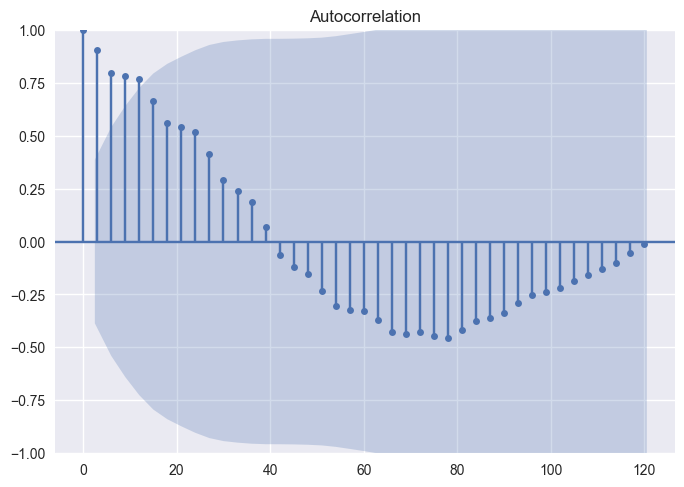

In [5]:
# Resample to weekly frequency (mean values for each week)
df_monthly = df.resample('M').mean()

# # ACF plot
plt.figure(figsize=(20, 10))

plot_acf(df_monthly['Price'], lags=np.arange(0, len(df_monthly), 3), alpha=0.05)#, lags= np.arange(100)) #Price_log_diff

plt.show()

<Figure size 2000x1000 with 0 Axes>

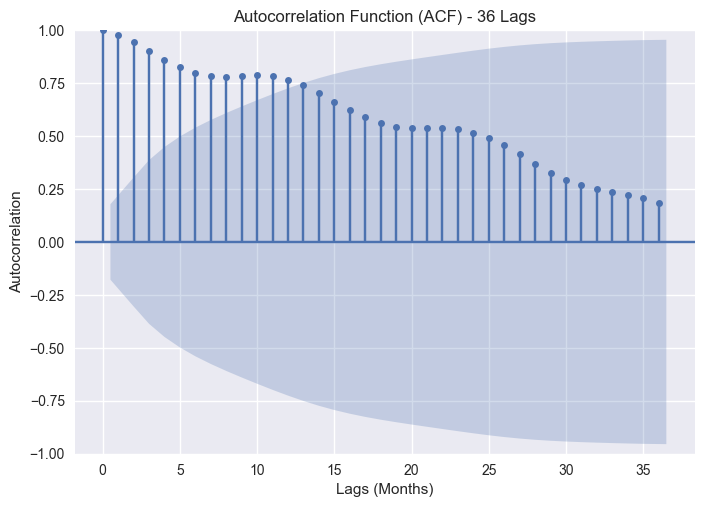

In [6]:
# Extend ACF plot to 36 lags (3 years)
plt.figure(figsize=(20, 10))  # Adjust figure size for better visualization
plot_acf(df_monthly['Price'], lags=36, alpha=0.05)  # Set lags=36
plt.title('Autocorrelation Function (ACF) - 36 Lags') # add a title
plt.xlabel('Lags (Months)') # add x label
plt.ylabel('Autocorrelation') # add y label
plt.show()


<Figure size 2000x1000 with 0 Axes>

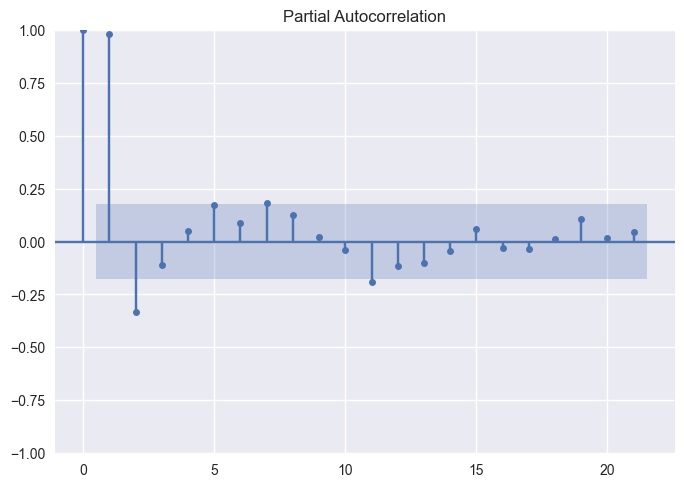

In [7]:
# # ACF plot
plt.figure(figsize=(20, 10))
plot_pacf(df_monthly['Price'])
plt.show()

Analyze Detrended Data: Once the trend is removed it is possible to notice:
- ACF:
    - ACF exhibits gradual decay but with some significant spikes at certain lags.
    - This suggests a moving average (MA) component (q > 0).
    - There are some significant spikes around the 6th and 12th lags. This suggests a seasonal component.


- PACF:
    - The PACF plot shows a significant spike at lag 1 and possibly lag 2, 3, 4.
    - This suggests an autoregressive (AR) component (p >= 1).
    - No strong seasonal pattern in PACF, but since ACF shows seasonality at 12 lags, a seasonal AR term (P) might be necessary.

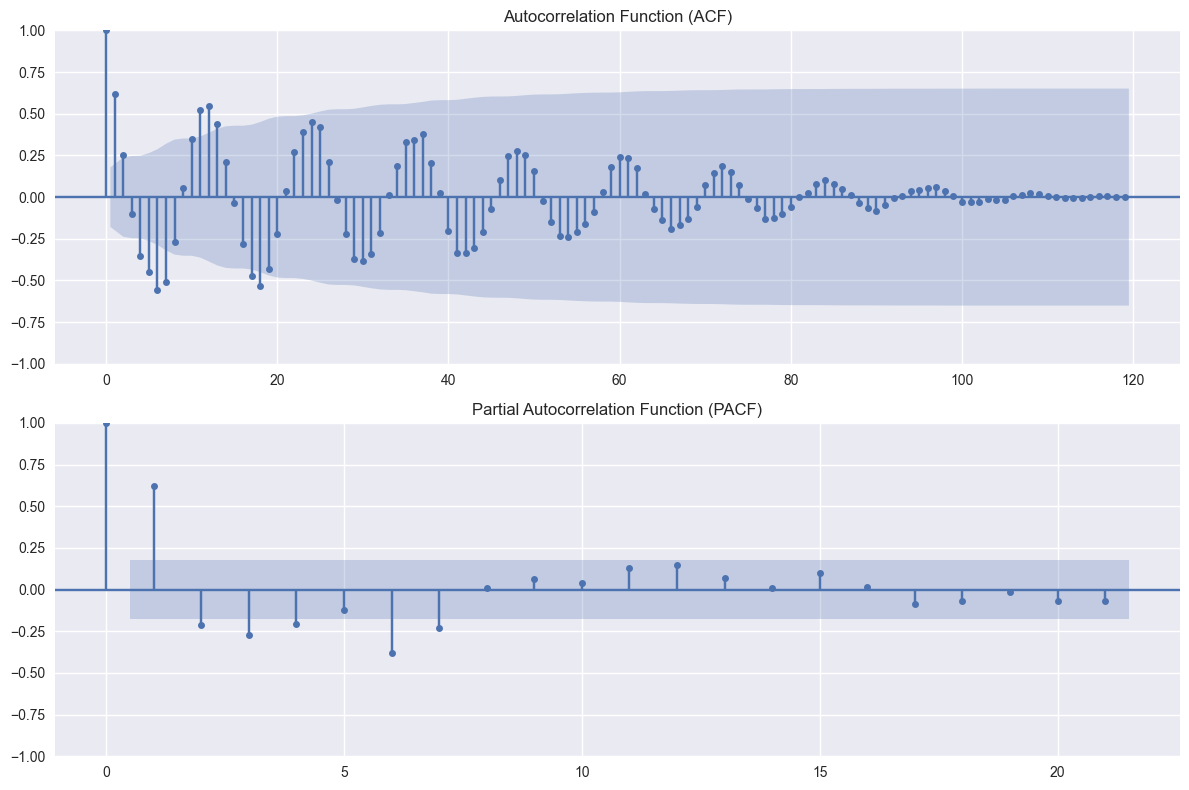

In [8]:
df_monthly["Price_differencing"] = df_monthly["Price"].diff()
df_monthly = df_monthly[~df_monthly["Price_differencing"].isnull()]
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 2 rows, 1 column

# Plot ACF
plot_acf(df_monthly['Price_differencing'] , 
         lags=np.arange(0, len(df_monthly)),  
  
         ax=axes[0])  # Place it in the first subplot
axes[0].set_title("Autocorrelation Function (ACF)")

# Plot PACF
plot_pacf(df_monthly['Price_differencing'] ,  
          alpha=0.05,  
          ax=axes[1])  # Place it in the second subplot
axes[1].set_title("Partial Autocorrelation Function (PACF)")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


Before applying the model, it is essential to check if the time series is stationary. Best practices recommend using the Augmented Dickey-Fuller (ADF) test for this purpose. By examining the p-value, we can determine that the time series lacks significant trends, allowing us to reject the null hypothesis and confirm that the time series is stationary. Once stationarity is established, I proceed with applying the SARIMA model. Although an ARIMA model might have seemed like the instinctive choice, the presence of a seasonal component led me to experiment carefully a different model. Ultimately, a SARIMA model with order (1,1,2) and a seasonal order of (1,0,1,12) was applied.

In [9]:
result = adfuller(df_monthly['Price_differencing'])  # Drop NaN values if differencing created any

# Print the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] < 0.05:
    print("The series is stationary (reject H0)")
else:
    print("The series is NOT stationary (fail to reject H0)")

ADF Statistic: -8.400317601499612
p-value: 2.2405656280230277e-13
Critical Values: {'1%': np.float64(-3.489589552580676), '5%': np.float64(-2.887477210140433), '10%': np.float64(-2.580604145195395)}
The series is stationary (reject H0)


In [10]:
# Split the data into train and test
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly[0:train_size], df_monthly[train_size:len(df)]


# Fit SARIMAX on the original data (not differenced)
model = SARIMAX(train['Price'], 
                order=(1, 1, 2),   # d = trend differencing
                seasonal_order=(1, 0, 1, 12),  # D = seasonal differencing
                enforce_stationarity=False, 
                enforce_invertibility=False)

result = model.fit()

aic = result.aic
bic = result.bic

print(f"AIC: {aic}")
print(f"BIC: {bic}")

AIC: 795.7670422339979
BIC: 810.0592020420412


In [11]:
# Make predictions on the test set
start = test["Price"].index[0]  # Start of the test period
end = test["Price"].index[-1]   # End of the test period
predictions = result.get_prediction(start=start, end=end)

# Get predicted values and confidence intervals
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

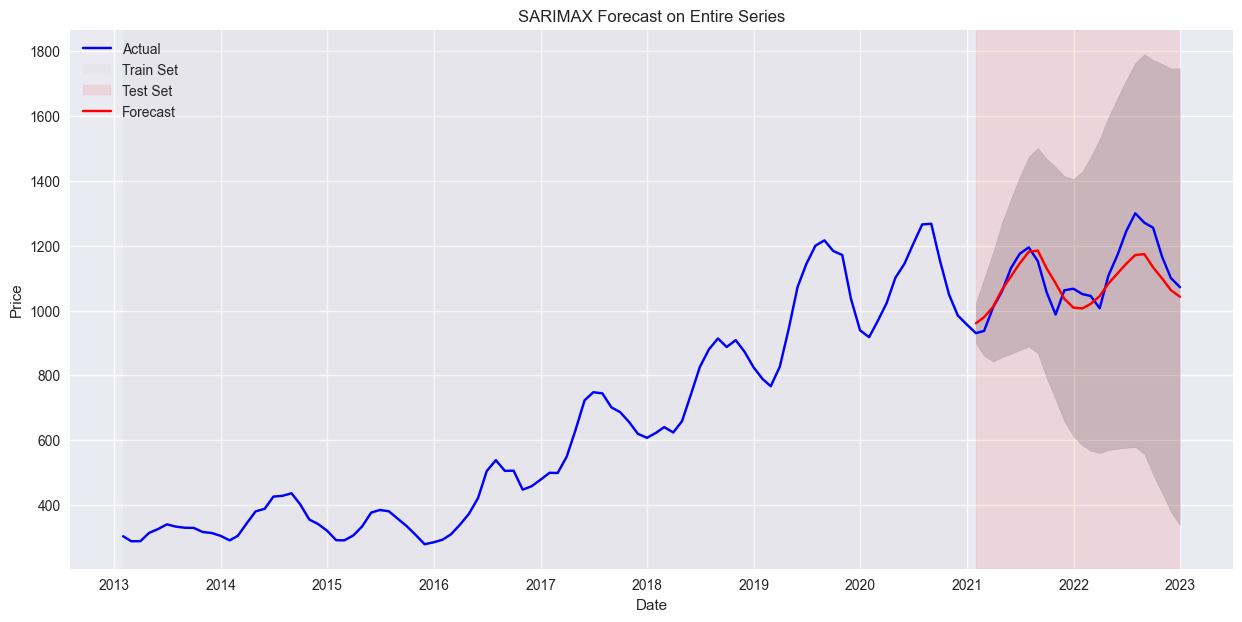

RMSE: 61.138701953899954


c:\Users\matte\anaconda3\envs\myenv1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
plt.figure(figsize=(15, 7))  # Adjust figure size for better visualization

# Plot the entire actual series
plt.plot(df_monthly.index, df_monthly['Price'], label='Actual', color='blue')
plt.axvspan(train.index[0], train.index[-1], alpha=0.2, color='lightgray', label='Train Set')
plt.axvspan(test.index[0], test.index[-1], alpha=0.2, color='lightcoral', label='Test Set')
plt.plot(test.index, predicted_mean, label='Forecast', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=.15)


plt.title('SARIMAX Forecast on Entire Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

rmse = mean_squared_error(test['Price'], predicted_mean, squared=False)
print(f"RMSE: {rmse}")

Based on the residuals analysis, we can assess the following:

- In the top-left chart, the residuals generally fluctuate around zero, which is a positive sign. However, there appears to be a slight increase in volatility (variance) in the earlier part of the time series (before 2017) and also towards the end, just before 2020. This suggests potential heteroscedasticity (non-constant variance). There are no obvious long-term trends or clear seasonal patterns, which is a favorable outcome.

- In the top-right chart, the histogram is roughly bell-shaped, though it appears slightly skewed to the right. The KDE line closely follows the histogram but deviates a bit from the N(0,1) line, particularly in the tails. This indicates that the residuals may not be perfectly normally distributed.

- In the bottom-left chart, most of the points are close to the line, but there are noticeable deviations in the tails, especially in the lower tail. This reinforces the previous indication that the residuals might not be perfectly normal.

- In the bottom-right chart, most autocorrelations are within the confidence bands, which is good. However, there is a slight negative autocorrelation at lag 3. While it's not large, it suggests that the model might not have fully captured all short-term dependencies in the data.

Overall, while the residuals generally behave positively, as shown in the charts, the predicted values do not seem to follow the actual development of the time series closely. One potential improvement would be addressing the heteroscedasticity by applying a logarithmic transformation to the series.

[]

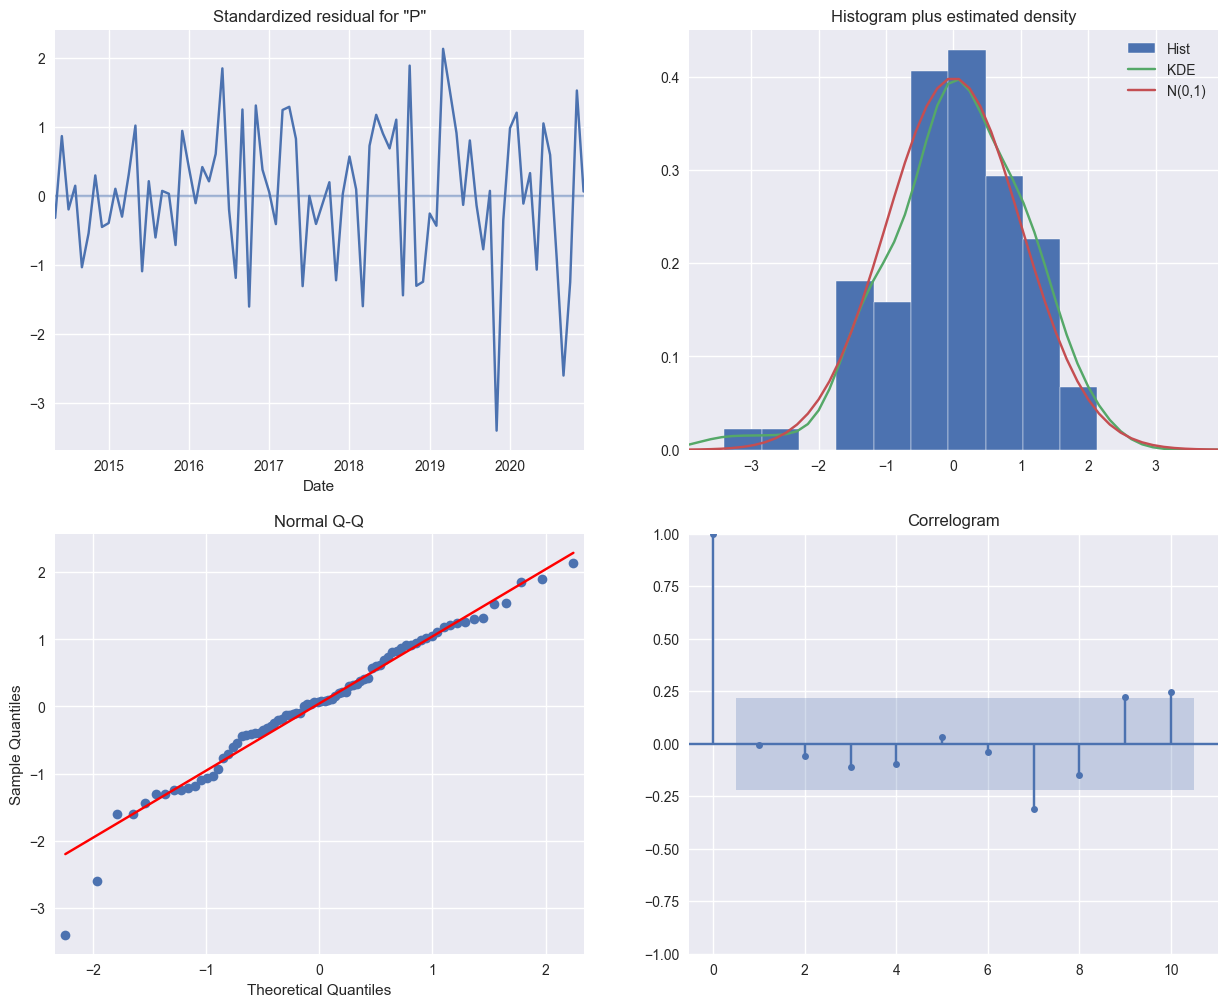

In [13]:
result.plot_diagnostics(figsize=(15, 12))
plt.plot()

### 1.3 Few consideration on the daily ts

As previously mentioned, the model built on the daily time series fails to provide meaningful insights when predicting values in the test set. However, to demonstrate the experimentation process and the conclusions drawn, I decided to include it in my analysis.

Based on prior insights, the time series was first transformed using a logarithmic transformation, and the newly created price series was detrended through differencing. After these preprocessing steps, I plotted the ACF and PACF. Unfortunately, identifying significant lags and determining the appropriate order for the ARIMA model proved challenging. Apart from a significant spike at lag 0, there were no clear patterns, leading me to implement an ARIMA model with an order of (0,1,0).

As expected, the model's performance was poor. The actual vs. predicted values chart clearly illustrates that the model fails to capture the underlying pattern of the time series.

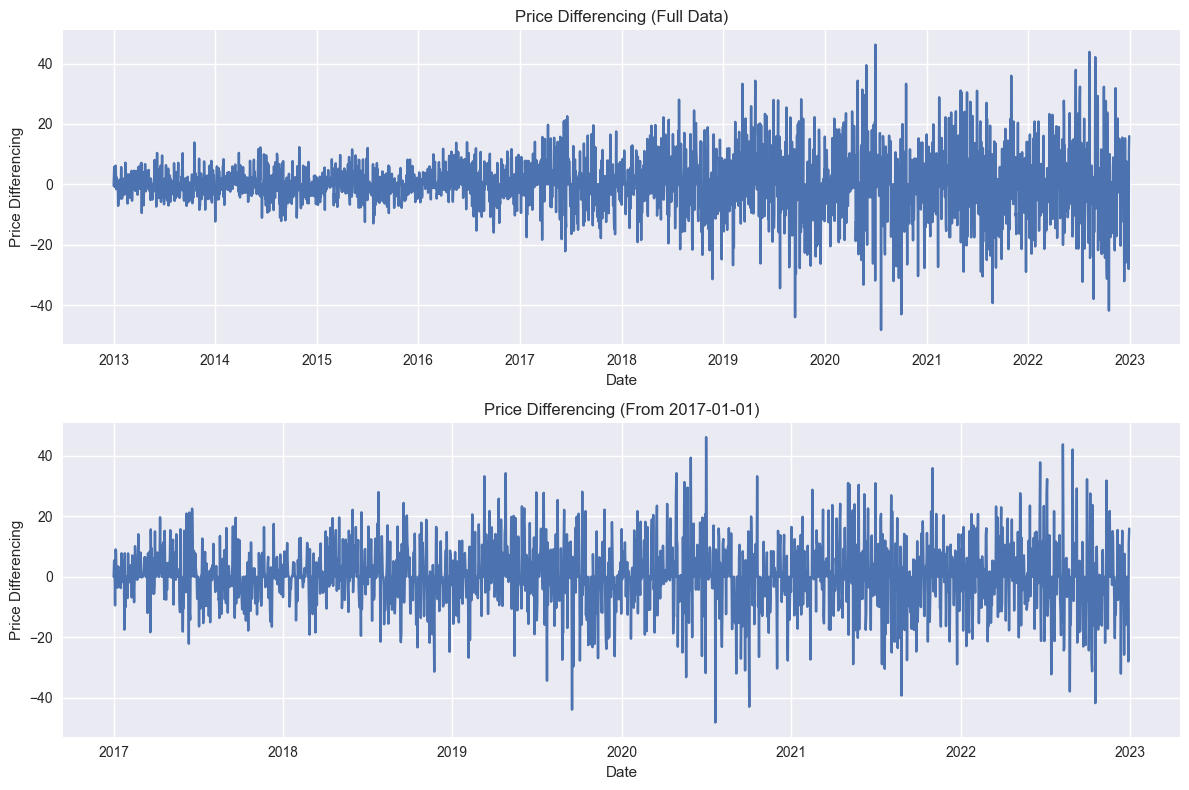

In [14]:
df_copy = df.copy()
df_copy["Price_differencing"] = df_copy["Price"].diff()
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 2 rows, 1 column

# Plot 1: Full data
sns.lineplot(data=df_copy, x=df_copy.index, y="Price_differencing", ax=axes[0])
axes[0].set_title("Price Differencing (Full Data)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price Differencing")

# Plot 2: Data from 2017-01-01 onwards
subset = df_copy[df_copy.index >= "2017-01-01"]  # Create the subset efficiently
sns.lineplot(data=subset, x=subset.index, y="Price_differencing", ax=axes[1])  # Use subset's index
axes[1].set_title("Price Differencing (From 2017-01-01)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price Differencing")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

To formally check whether the series in stationaty, we can consider the Augmented Dickey-Fuller Test (ADF). Given the p-value a very small number close to zero and therefore smaller than the significance level, we can reject the null hypothesis stating that the series is stationary.

In [15]:
df_copy = df_copy.dropna()
result = adfuller(df_copy['Price_differencing'])  # Drop NaN values if differencing created any

# Print the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] < 0.05:
    print("The series is stationary (reject H0)")
else:
    print("The series is NOT stationary (fail to reject H0)")

ADF Statistic: -10.572622559812006
p-value: 7.239452640018001e-19
Critical Values: {'1%': np.float64(-3.432152735611742), '5%': np.float64(-2.8623365480522964), '10%': np.float64(-2.567194014828981)}
The series is stationary (reject H0)


However, as seen above we detected an increasing level of heteroskedasticity in the right part of the chart, hence towards the en ot the series. By looking at the plot below we can observe the following:
- The red line (rolling standard deviation) shows a gradual increase, especially from 2019 onward.
- The fluctuations in the blue series (price differencing) also become more extreme over time.
- This suggests that the variance is not constant, which is a sign of heteroskedasticity.

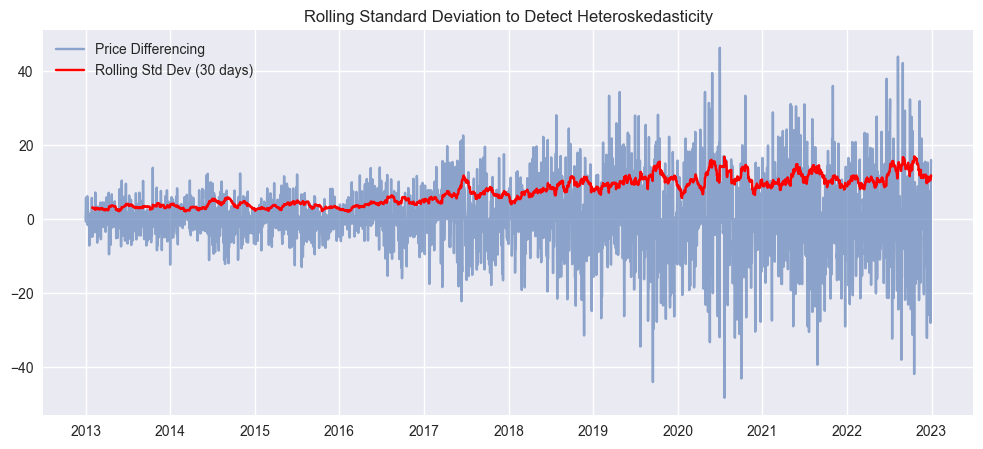

In [16]:
rolling_std = df_copy['Price_differencing'].rolling(window=30).std()

# Plot the original series and rolling std deviation
plt.figure(figsize=(12, 5))
plt.plot(df_copy.index, df_copy['Price_differencing'], label="Price Differencing", alpha=0.6)
plt.plot(df_copy.index, rolling_std, label="Rolling Std Dev (30 days)", color='red')
plt.legend()
plt.title("Rolling Standard Deviation to Detect Heteroskedasticity")
plt.show()

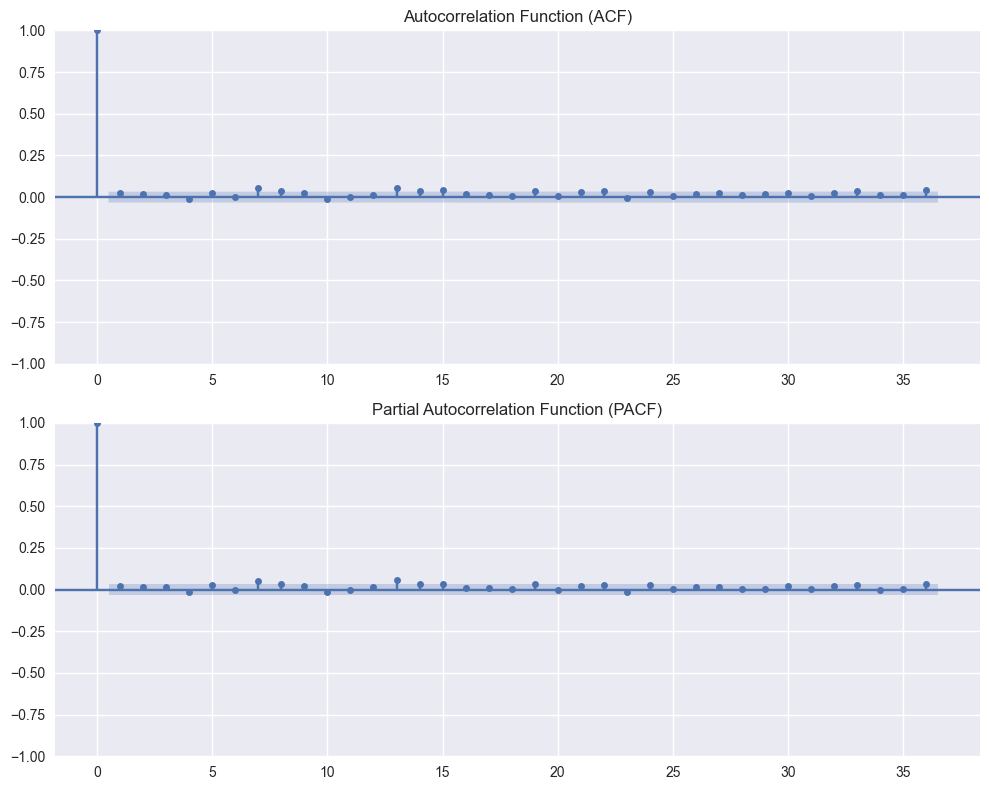

In [17]:
df_copy["Price_log"] = np.log(df_copy["Price"])
df_copy["Price_log_diff"] = df_copy["Price_log"].diff()
df_copy = df_copy[~df_copy["Price_log_diff"].isnull()]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column, adjust figure size as needed

# Plot ACF on the first subplot (axes[0])
plot_acf(df_copy["Price_log_diff"], ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF on the second subplot (axes[1])
plot_pacf(df_copy["Price_log_diff"], ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout() 
plt.show()

 Given that the data has already been differenced (d=1), and there are no significant spikes in the ACF or PACF plots beyond lag 0, the most appropriate model is ARIMA(0,1,0).

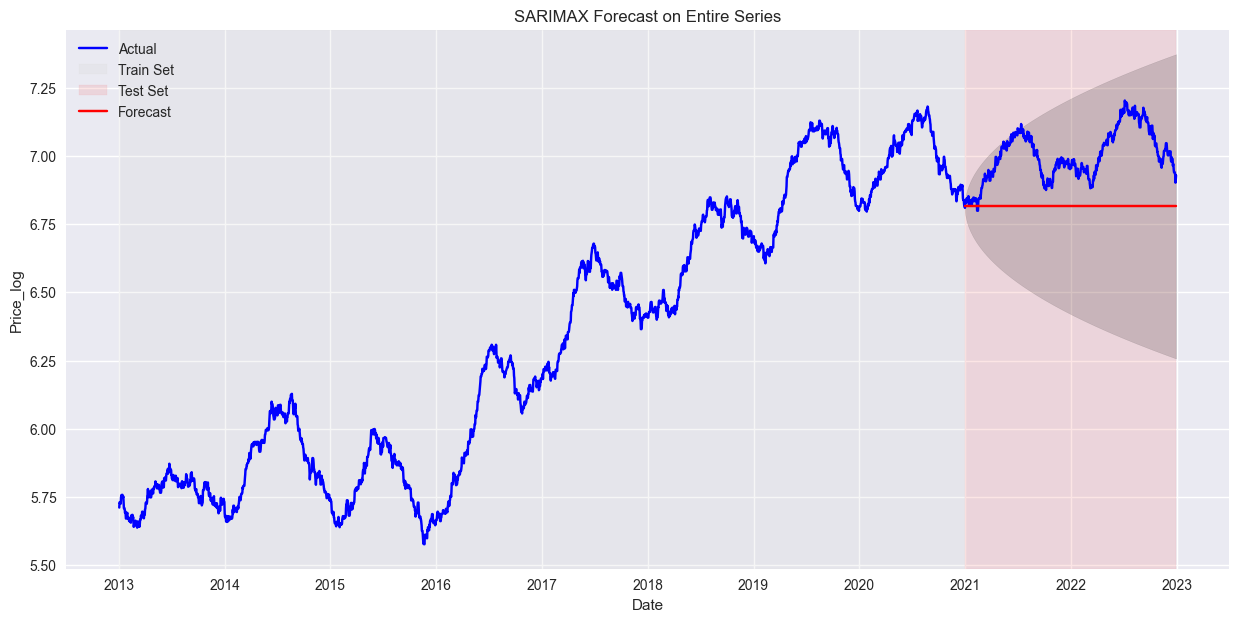

RMSE: 0.21084126407991138


c:\Users\matte\anaconda3\envs\myenv1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
train_size = int(len(df_copy) * 0.8)
train, test = df_copy[0:train_size], df_copy[train_size:len(df_copy)] # Corrected slice

model = ARIMA(train['Price_log'], order=(0, 1, 0))
model_fit = model.fit()

# Make predictions on the test set
start = test["Price_log"].index[0]  # Start of the test period
end = test["Price_log"].index[-1]   # End of the test period
predictions = model_fit.get_prediction(start=start, end=end)

# Get predicted values and confidence intervals
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

plt.figure(figsize=(15, 7))  # Adjust figure size for better visualization

# Plot the entire actual series
plt.plot(df_copy.index, df_copy['Price_log'], label='Actual', color='blue')
plt.axvspan(train.index[0], train.index[-1], alpha=0.2, color='lightgray', label='Train Set')
plt.axvspan(test.index[0], test.index[-1], alpha=0.2, color='lightcoral', label='Test Set')
plt.plot(test.index, predicted_mean, label='Forecast', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=.15)


plt.title('SARIMAX Forecast on Entire Series')
plt.xlabel('Date')
plt.ylabel('Price_log')
plt.legend()
plt.show()

rmse = mean_squared_error(test['Price_log'], predicted_mean, squared=False)
print(f"RMSE: {rmse}")

## 2. Applaying feature engineering
Given the challenges of the ARIMA model on the daily time series and the poor performances of the SARIMA model on the monthly time series—particularly its inability to generate price predictions at the required granularity—I propose transitioning to a supervised machine learning approach. This approach would begin with feature engineering. Initially, I would extract basic features from the date index, such as day, month, and year. Then, I would incorporate more complex features, including weekly and monthly averages, as well as lag variables, to improve the model's predictive performance.

In [19]:
def fill_na_with_avg(df, column_name, freq='W', price_column='Price'):
    
    # Resample the DataFrame based on the chosen frequency and calculate the mean for each period
    resampled_mean = df[price_column].resample(freq).mean()
    df[column_name] = resampled_mean.reindex(df.index, method='ffill')
    mean_price_for_nan = df[df[column_name].isna()][price_column].mean()
    df[column_name].fillna(mean_price_for_nan, inplace=True)

    return df[column_name]

def create_features(df):   
    """
    Create additional features from the date index
    """
    df["dayofweek"] = df.index.day_of_week.astype(int)
    df["dayofyear"] = df.index.day_of_year.astype(int)
    df["dayofmonth"] = df.index.day
    df["month"] = df.index.month.astype(int)
    df["quarter"] = df.index.quarter.astype(int)
    df["year"] = df.index.year.astype(int)
    df["weekofyear"] = df.index.isocalendar().week

    ##wekly mean
    #df["weekly_mean"] = fill_na_with_avg(df, "weekly_mean", freq="W", price_column="Price")

    ##monthly mean
    #df["monthly_mean"] = fill_na_with_avg(df, "monthly_mean", freq="M", price_column="Price")

    ##quarterly mean
    df["quarterly_mean"] = fill_na_with_avg(df, "quarterly_mean", freq="Q", price_column="Price")


    return df

df = create_features(df)

C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1259468906.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  resampled_mean = df[price_column].resample(freq).mean()
C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1259468906.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mean_price_for_nan, inplace=True)


### 2.1 Creating Lag features
Based on insights from our previous analysis, which confirmed a recurring seasonal pattern with price peaks in the middle of each year, I decided to incorporate lagged variables. Lagged variables capture the relationship between a data point and its past values, which is particularly relevant in time series analysis where current values often depend on historical ones (e.g., yesterday's price influencing today's price).

To account for the observed seasonal fluctuations, I included lags that align with the annual pattern. Additionally, as shown in the autocorrelation function plot, we see significant spikes every six months. To capture this biannual cycle, I introduced lags at six-month intervals. This approach allows the model to detect both yearly and semi-annual patterns effectively.

In [20]:
def creating_lags(df, n_lags=4, start=180):
    """
    Create n lagged features with a step size that is double the starting point.
    
    Parameters:
        df (pd.DataFrame): The original DataFrame with a datetime index and a 'Price' column.
        n_lags (int): Number of lagged features to create.
        start (int): The starting lag (e.g., 30 days).
    
    Returns:
        pd.DataFrame: The DataFrame with added lagged features.
        list: List of created lag column names.
    """
    # Set step to be twice the start
    step = 180

    # Convert 'Price' column to dictionary for fast lookup
    price_target = df["Price"].to_dict()
    
    # Create lagged features
    for i in range(n_lags):
        lag = start + (i * step)
        df[f"lag_{lag}"] = (df.index - pd.Timedelta(days=lag)).map(price_target)

    # Fill NaN values with 0
    df.fillna(0, inplace=True)

    # Extract the list of created lag features
    lags = df.columns[-n_lags:].to_list()
    
    return df, lags


df, lags = creating_lags(df)
df

,Price,dayofweek,dayofyear,dayofmonth,month,quarter,year,weekofyear,quarterly_mean,lag_180,lag_360,lag_540,lag_720
Date,,,,,,,,,,,,,
2012-12-31,300.000000,0,366,31,12,4,2012,1,300.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01,299.553248,1,1,1,1,1,2013,1,300.000000,0.000000,0.000000,0.000000,0.000000
2013-01-02,302.043389,2,2,2,1,1,2013,1,300.000000,0.000000,0.000000,0.000000,0.000000
2013-01-03,307.849084,3,3,3,1,1,2013,1,300.000000,0.000000,0.000000,0.000000,0.000000
2013-01-04,307.091766,4,4,4,1,1,2013,1,300.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1030.524458,0,360,26,12,4,2022,52,1275.455663,1304.321696,1049.280854,1210.587797,931.217927
2022-12-27,1022.667013,1,361,27,12,4,2022,52,1275.455663,1283.044382,1049.280854,1205.268275,938.799391
2022-12-28,994.676194,2,362,28,12,4,2022,52,1275.455663,1294.289636,1049.280854,1195.570052,926.043091


### 3. Visualize feature/target relationship
To further validate the previous observations, I have plotted box plots illustrating the price distribution across months and quarters. Both visualizations reveal a clear seasonal pattern recurring each year, with a noticeable peak around September and October. Meanwhile, the rightmost chart in the figure unmistakably highlights a steady upward trend in prices over the years. The median price for each year is generally higher than the previous year’s, indicating a consistent long-term increase.

- Given this strong yearly seasonality, incorporating lagged variables that align with the seasonal cycle (12 months or approximately 365 days) is a logical approach. Lags of 12, 24, and potentially 36 months would help the model capture these recurring patterns effectively.

- Additionally, the monthly box plots reveal a distinct shift in price behavior around mid-year, particularly between June and July. This suggests that a lag of approximately 180 days (6 months) could be relevant, as it may help capture the transition in price levels between the first and second halves of the year.

Lastly, I also considered incorporating short-term lags. However, as I will discuss later, this approach led to issues—the model struggled to predict future data accurately given the feature set provided.

C:\Users\matte\AppData\Local\Temp\ipykernel_18056\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\matte\AppData\Local\Temp\ipykernel_18056\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\matte\AppData\Local\Temp\ipykernel_18056\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


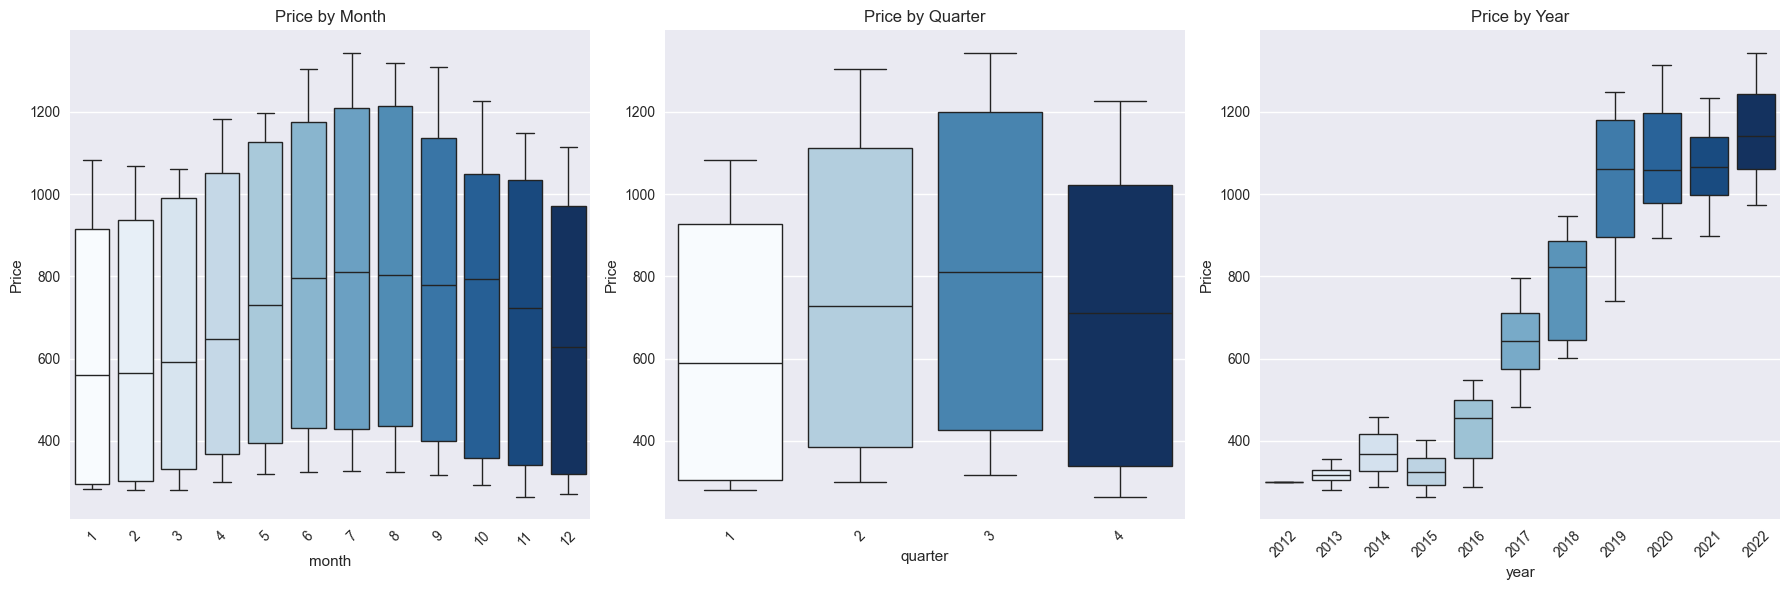

In [21]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Boxplot by Month ---
sns.boxplot(data=df, x="month", y="Price", ax=axes[0], hue = "month", legend= False, palette="Blues")
axes[0].set_title("Price by Month")

# Boxplot by Quarter ---
sns.boxplot(data=df, x="quarter", y="Price", ax=axes[1], hue = "quarter", legend= False, palette="Blues")
axes[1].set_title("Price by Quarter")

# Boxplot by Year ---
sns.boxplot(data=df, x="year", y="Price", ax=axes[2], hue = "year", legend= False, palette="Blues")
axes[2].set_title("Price by Year")

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### 4. Train test split

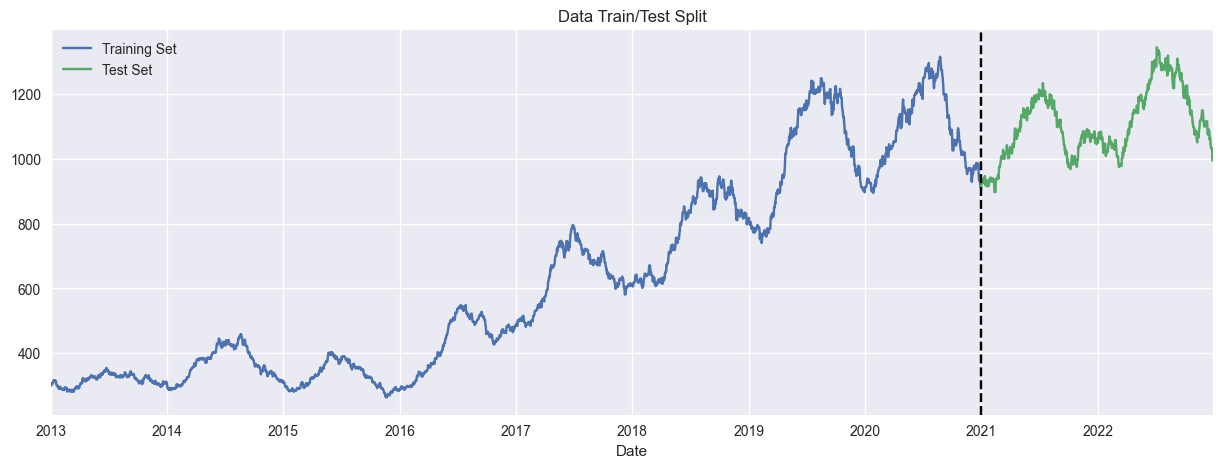

Length of the training set 2921
Length of the test set 731


In [22]:
#get the date to split between training and test set
df_copy = df.copy()
df_copy = df_copy.reset_index()
split_index = int(len(df_copy) * 0.8)

date_index = df_copy.iloc[split_index]["Date"]
df_copy = df_copy.set_index("Date")


# Split the data based on the index
train = df_copy.iloc[:split_index]
test = df_copy.iloc[split_index:]

# Create a plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot both training and testing data (assume you want to plot the entire dataframe)
train["Price"].plot(ax=ax, label='Training Set')
test["Price"].plot(ax=ax, label='Test Set')

# Add vertical line at the split point
ax.axvline(pd.to_datetime(df.index[df.index==date_index]), color='black', ls='--')

# Add legend and title
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/Test Split')

# Show the plot
plt.show()

print("Length of the training set", len(train))
print("Length of the test set", len(test))

### 4.1 Training the model with one split
After creating all the features and analyzing the nature of the time series, I can proceed with building the model. I have chosen XGBoost because, based on my experience, decision tree algorithms are widely used and accepted across various business scenarios. This is primarily due to three key advantages:

- Interpretability: Decision trees algorithms offer insights into the most influential features, though the choice of feature importance metric (e.g., weight or gain) can significantly impact the analysis. While this is a topic of ongoing discussion, several studies suggest that none of these metrics provide a completely unbiased assessment of the features truly driving predictions. Shapley values, on the other hand, may offer a more reliable approach. Yet, due to time constraints and to stay focused on the main objective, I will not delve into this aspect further. Instead, I will rely on the default metric used for calculating feature importance.
- Efficiency: They offer fast training times, making them highly scalable.
- Flexibility: They effectively capture both linear and nonlinear relationships within the data.

However, decision trees have drawbacks, particularly their tendency to overfit. To mitigate this, it is essential to prune the number of trees trained when there's no improvement in the chosen evaluation metrics.


In [23]:
def creating_train_test_sets(df_copy, train, test):    
    features = df_copy.columns.to_list()
    features.remove("Price")
    target = "Price"

    #setting up training
    X_train = train[features]
    y_train = train[target]

    #setting up test
    X_test = test[features]
    y_test = test[target]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = creating_train_test_sets(df_copy, train=train, test=test)

def training_model_and_getting_predictions(X_train, y_train, X_test, y_test):

    """
    Training the model and returning prediciton and model object
    """

    #setting up model
    reg_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',   
                            n_estimators=500,
                            early_stopping_rounds=10,
                            objective='reg:squarederror',
                            max_depth=3,
                            learning_rate=0.1)

    reg_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg_model.predict(X_test)
    return y_pred, reg_model

y_pred, model_final = training_model_and_getting_predictions(X_train, y_train, X_test, y_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
score_2 = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {score}")
print(f"Mean Absolute Percentage Error: {score_2}")

[0]	validation_0-rmse:625.07410	validation_1-rmse:1002.45265
[91]	validation_0-rmse:16.07914	validation_1-rmse:98.16714
Mean Squared Error: 9495.7089
Root Mean Squared Error: 97.4459282930399
Mean Absolute Percentage Error: 0.07674801347601994


After splitting the data into training and test sets—without shuffling, to preserve the sequential nature of the time series—I trained the model and evaluated it on the remaining 20% of the dataset.

The results show a Root Mean Squared Error (RMSE) of 97.45, indicating the model's predictive performance. Additionally, the top three most influential features, in decreasing order, are lag_360, quarterly mean, and year. This suggests that data points from approximately one year prior play a fundamental role in the model's ability to forecast future values.

C:\Users\matte\AppData\Local\Temp\ipykernel_18056\616079977.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


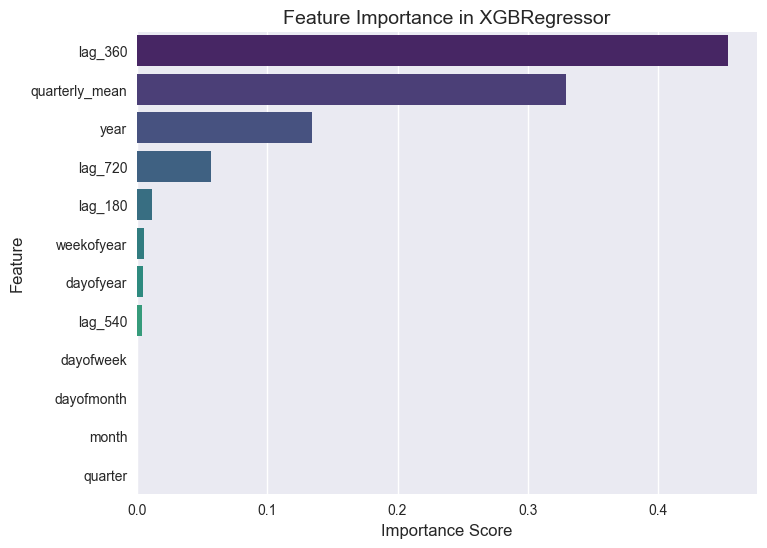

In [24]:
importance_values = model_final.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Feature names
    'Importance': importance_values  # Corresponding importance scores
})

# Sort by importance (descending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 6))

# Create a horizontal bar plot
sns.barplot(
    x=feature_importance_df["Importance"], 
    y=feature_importance_df["Feature"], 
    palette="viridis"
)

# Add title and labels
plt.title("Feature Importance in XGBRegressor", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Show the plot
plt.show()



In contrast, as shown in the next figure—where the predicted and actual values are plotted together—the predicted line does not closely follow the actual trend of the series. In fact, there are areas where the error fluctuates by several hundred units.

If we had instead used a set of variables incorporating short-term lags, we would have observed significant improvements in the model’s performance metrics. However, this improvement would have been short-lived. When predicting future values, the model would become overly reliant on these short-term features, which would not be available when forecasting a year ahead, ultimately compromising its accuracy in long-term predictions.

C:\Users\matte\AppData\Local\Temp\ipykernel_18056\562165104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction_one_split"] = y_pred


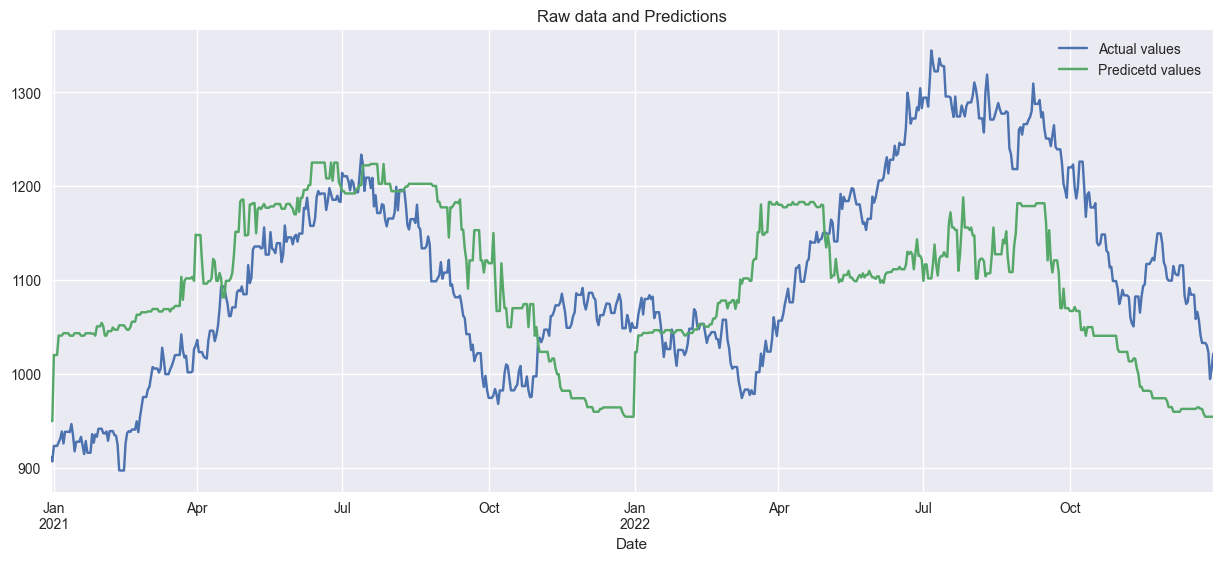

In [25]:
test["prediction_one_split"] = y_pred

ax = test["Price"].plot(figsize=(15, 6))
test["prediction_one_split"].plot(ax=ax)
plt.legend(["Actual values", "Predicetd values"])
plt.title("Raw data and Predictions")
plt.show()

Based on the curve plot, we can observe the following:

- The Training RMSE (blue line) steadily decreases and reaches a low value.
- The Validation RMSE (red line) decreases initially, but then flattens at a higher value compared to the training RMSE.
- This pattern suggests that the model is overfitting. While it performs well on the training data, it fails to generalize effectively to the validation set. The increasing gap between training and validation RMSE indicates that the model has learned patterns specific to the training data, but struggles to capture broader trends in unseen data. However, the overfitting is mild.

This highlights that early stopping alone was not sufficient. It may be beneficial to incorporate regularization techniques, such as L1 or L2 regularization, to prevent the model from learning noise and improve generalization.

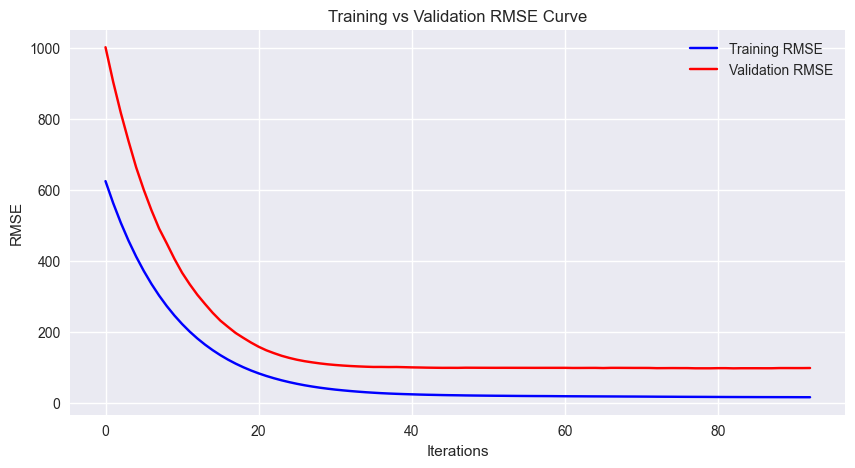

In [26]:
results = model_final.evals_result_
plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['rmse'], label="Training RMSE", color='blue')
plt.plot(results['validation_1']['rmse'], label="Validation RMSE", color='red')
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE Curve")
plt.legend()
plt.show()

### 4.2 Training the model with cross validation split

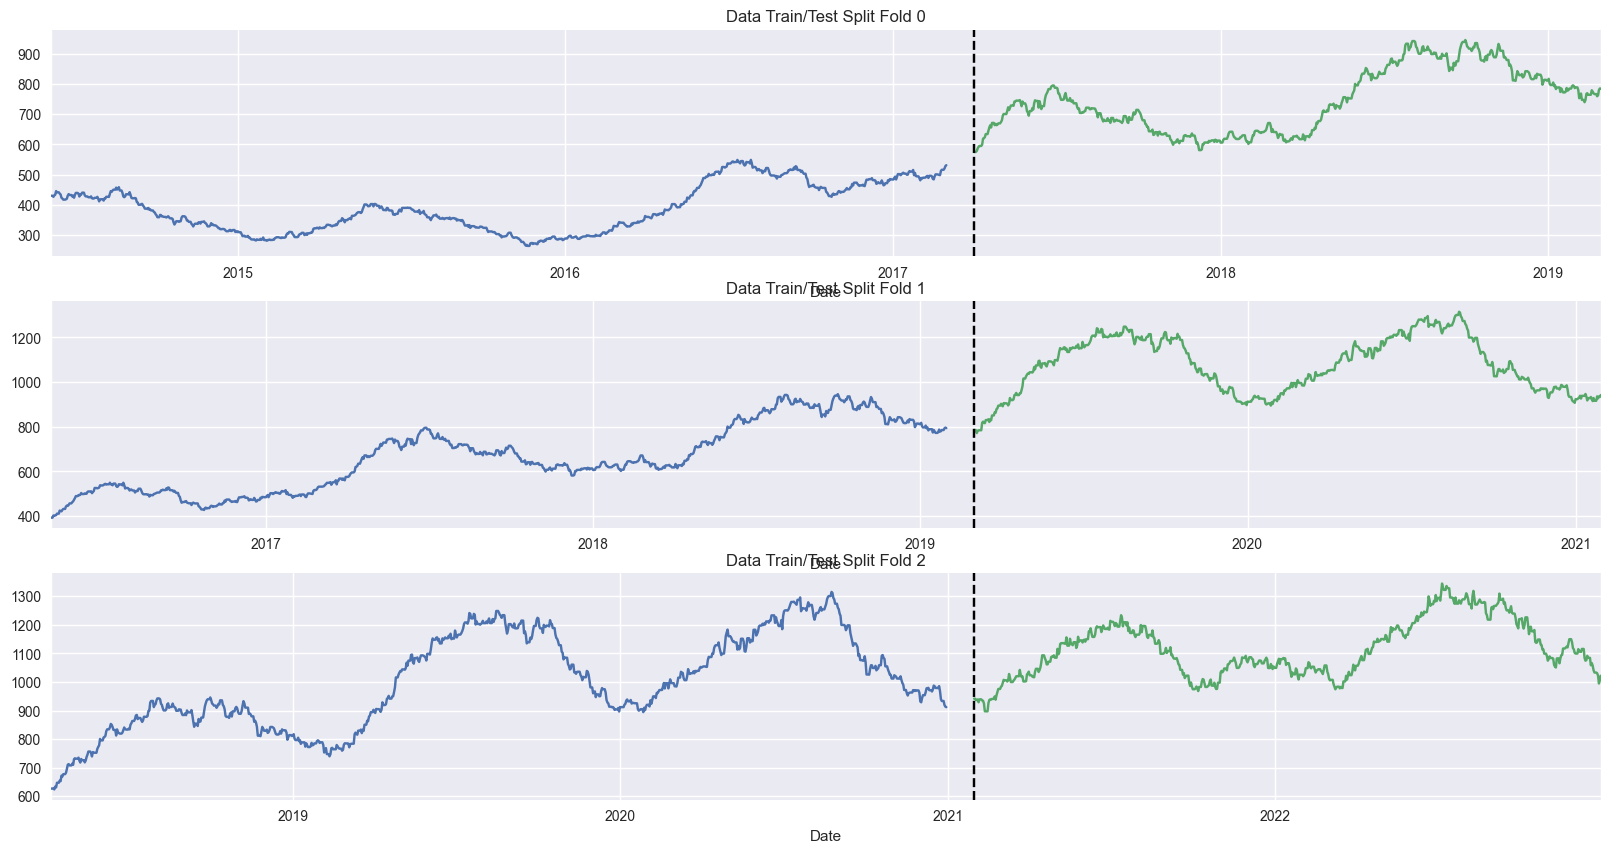

In [27]:
tss = TimeSeriesSplit(n_splits = 3, gap= 30,  max_train_size=1000, test_size=700)

fig, axs = plt.subplots(tss.n_splits, 1, figsize = (20, 10), sharex= False)
fold = 0
for train_idx, val_idx in tss.split(df_copy):
    train = df_copy.iloc[train_idx]
    test = df_copy.iloc[val_idx]
    train['Price'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Price'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [28]:
preds = []
scores = []
score_2 = []
for train_idx, val_idx in tss.split(df_copy):
    train = df_copy.iloc[train_idx]
    test = df_copy.iloc[val_idx]
    
    X_train, X_test, y_train, y_test = creating_train_test_sets(df_copy, train=train, test=test)
    y_pred, model = training_model_and_getting_predictions(X_train, y_train, X_test, y_test)
    
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    score_percentage = mean_absolute_percentage_error(y_test, y_pred)
    score_2.append(score_percentage)
    scores.append(score)

[0]	validation_0-rmse:356.74336	validation_1-rmse:701.03438
[84]	validation_0-rmse:7.05819	validation_1-rmse:260.35941
[0]	validation_0-rmse:608.37100	validation_1-rmse:996.94826
[69]	validation_0-rmse:11.13759	validation_1-rmse:276.47353


[0]	validation_0-rmse:909.96218	validation_1-rmse:1009.22938
[78]	validation_0-rmse:15.85869	validation_1-rmse:90.70192


In [29]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print("------------------------")
print(f'Score across folds for percentage error{np.mean(score_2):0.4f}')
print(f'Fold scores for percentage error:{score_2}')

Score across folds 208.9511
Fold scores:[np.float64(259.9671391114606), np.float64(276.2236935712791), np.float64(90.66255388313682)]
------------------------
Score across folds for percentage error0.2015
Fold scores for percentage error:[np.float64(0.3050605310543899), np.float64(0.22878802766913445), np.float64(0.07069278054710103)]


### 4.3 Predicting the 2023 development of the time series
#### Conclusions
As outlined in the main track, the goal of the project is to predict the future development of the time series in 2023. In the function described below, I recreated the dataframe by incrementally extending the date until the end of 2023. This process involved replicating all the features on which the model had been trained, including the creation of lagged values for each respective date. The model then predicted the next X days. Once a set of predictions was made, those values were added back into the dataset, allowing the model to use them in generating subsequent predictions. This loop would continue until the full year was covered.

The plot below illustrates how the time series would look based on the model’s previous training, with the predictions shown in red. From my perspective, there are areas where the model could have been improved, such as by applying grid search to find the optimal combination of hyperparameters or by adding more features to the dataset. However, my key takeaway from careful experimentation is that, even with potential model improvements, predicting 2023’s development would remain a challenge.

Specifically, while incorporating short-term features like weekly or monthly price summaries might improve performance in the short term, these adjustments would not lead to a more accurate prediction for the entire year. Using very close lags (e.g., 10-20 days) causes the model to overfit the noise and short-term fluctuations in the data. As a result, these variables may dominate, making predictions unreliable over time. Furthermore, when predictions are used to generate future forecasts (iterative forecasting), small errors in early predictions can be amplified as they propagate through the process. Since the model relies on predicted values rather than actual true values, even minor inaccuracies early on can accumulate, distorting future predictions and leading to increasingly inaccurate outcomes. Over time, this causes the model to regress toward the mean or a constant value.

In contrast, using more distant lags (e.g., 100 or 200 days) allows the model to capture broader, more persistent trends, providing more reliable long-term predictions.

In [30]:
# Function to create lag features (from the past price values)
def create_lags(df, lags):
    df_with_lags = df.copy()
    for lag in lags:
        df_with_lags[f'lag_{lag}'] = df_with_lags['Price'].shift(lag)
    return df_with_lags


def predict_future(df, future_days=365, predict_every_n_days=60, lags=[180, 360, 540, 720], model=None):
    df_with_lags = create_lags(df, lags)

    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
    future_df = pd.DataFrame(index=future_dates)
    future_df["Predicted price"] = np.nan

    future_df["dayofweek"] = future_df.index.dayofweek.astype(int)
    future_df["dayofyear"] = future_df.index.day_of_year.astype(int)
    future_df["dayofmonth"] = future_df.index.day
    future_df["month"] = future_df.index.month.astype(int)
    future_df["quarter"] = future_df.index.quarter.astype(int)
    future_df["year"] = future_df.index.year.astype(int)
    future_df["weekofyear"] = future_df.index.isocalendar().week

    predictions = []

    for start_day in range(0, future_days, predict_every_n_days):
        future_subset = future_df.iloc[start_day:start_day + predict_every_n_days].copy() 

        # Fill weekly, monthly, and quarterly means *within* the loop
        #future_subset["weekly_mean"] = fill_na_with_avg(future_subset, "weekly_mean", freq="W", price_column="Predicted price")
        #future_subset["monthly_mean"] = fill_na_with_avg(future_subset, "monthly_mean", freq="M", price_column="Predicted price")
        future_subset["quarterly_mean"] = fill_na_with_avg(future_subset, "quarterly_mean", freq="Q", price_column="Predicted price")
        
        for i in range(len(future_subset)): # Iterate through each row of the subset
            current_date = future_subset.index[i]
            
            for lag in lags:
                lag_date = current_date - pd.Timedelta(days=lag)
                
                # Check if the lag_date is within the training data or previous predictions
                if lag_date in df_with_lags.index:
                    future_subset.loc[current_date, f'lag_{lag}'] = df_with_lags.loc[lag_date, 'Price']
                elif lag_date in future_df.index:
                    future_subset.loc[current_date, f'lag_{lag}'] = future_df.loc[lag_date, 'Predicted price']
                else:
                    future_subset.loc[current_date, f'lag_{lag}'] = np.nan # Or another appropriate fill value
                
        model_features = [
            'dayofweek', 'dayofyear', 'dayofmonth', 'month', 'quarter', 'year', 'weekofyear',
             'quarterly_mean'
        ] + [f'lag_{lag}' for lag in lags]

        predicted_values = model.predict(future_subset[model_features])
        future_subset["Predicted price"] = predicted_values

        predictions.extend(future_subset['Predicted price'].values)

        # Update df_with_lags with the new predictions (for use in subsequent predictions)
        new_predictions_series = pd.Series(future_subset["Predicted price"], index=future_subset.index)
        df_with_lags = pd.concat([df_with_lags, new_predictions_series.to_frame(name='Price')])

    future_df["Predicted price"] = predictions[:len(future_df)]  # Ensure correct length
    return future_df

In [31]:
future_df = predict_future(df_copy, future_days=365, predict_every_n_days=90, lags=[180, 360, 540, 720], model = model_final)

C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1259468906.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  resampled_mean = df[price_column].resample(freq).mean()
C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1259468906.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mean_price_for_nan, inplace=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1259468906.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future versio

C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1259468906.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  resampled_mean = df[price_column].resample(freq).mean()
C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1259468906.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mean_price_for_nan, inplace=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1259468906.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future versio

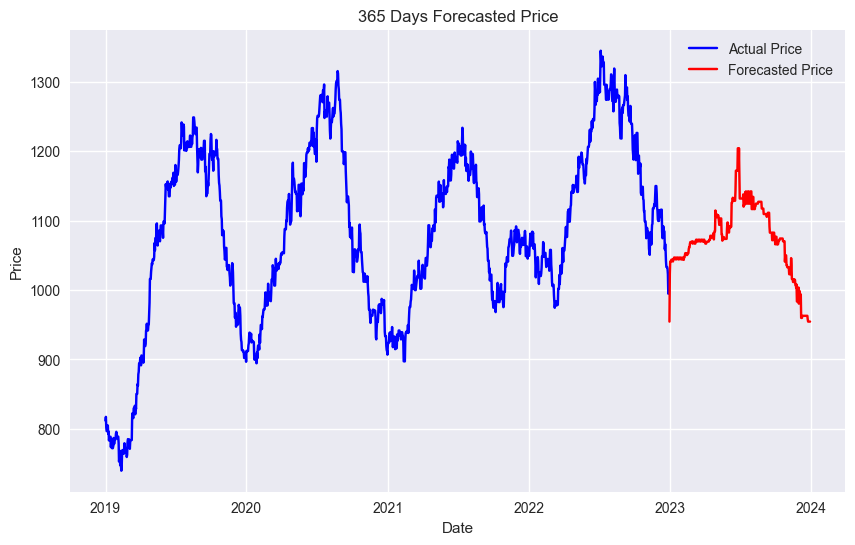

In [32]:

df_filtered = df_copy[df_copy.index >= "2019-01-01"]

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(df_filtered.index, df_filtered['Price'], label='Actual Price', color='blue')
plt.plot(future_df.index, future_df['Predicted price'], label='Forecasted Price', color='red')
plt.legend()
plt.title('365 Days Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

As shown in the image below, these are the results we would obtain when relying on features with short-term differences between timestamps. Specifically, in this case, I trained the model by incorporating features such as weekly and monthly means, along with price lags of 5, 10, 15, and 20 days. While the overall test set score is higher compared to the chosen model, the newly trained model heavily relies on short-term features. As a result, the predictions for 2023 do not appear to be accurate

And here's another one, displayed programmatically:


<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\matte\AppData\Local\Temp\ipykernel_18056\1030055074.py:4: SyntaxWarning: invalid escape sequence '\S'
  Image(filename="C:/Users/matte/Documents/expana_job_interview\Screenshot 2025-02-10 191518.jpg")


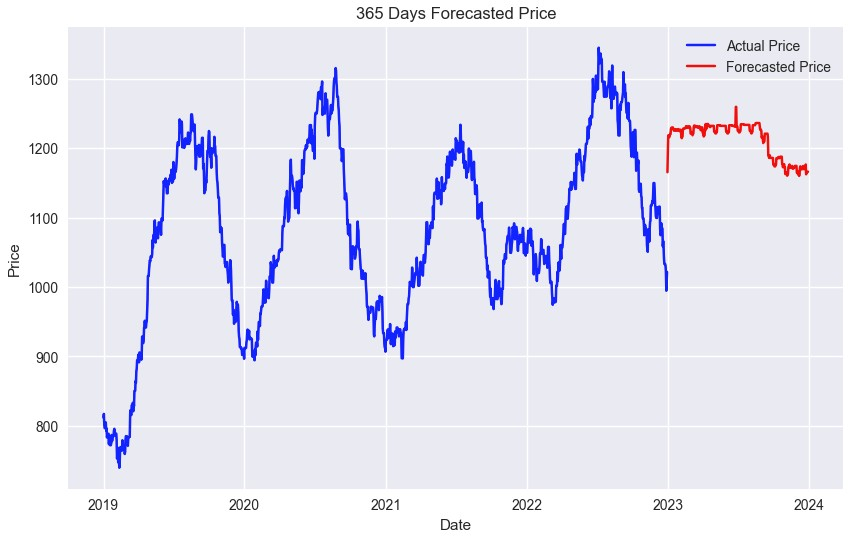

In [33]:
from IPython.display import Image

print("And here's another one, displayed programmatically:")
Image(filename="C:/Users/matte/Documents/expana_job_interview\Screenshot 2025-02-10 191518.jpg")

In [34]:
# future_lags = lags
# df_only_price = df[["Price"]]

# last_date = df_only_price.index[-1]
# future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365)
# future_df = pd.DataFrame(index=future_dates)
# future_df["dayofweek"] = future_df.index.day_of_week.astype(int)
# future_df["dayofyear"] = future_df.index.day_of_year.astype(int)
# future_df["dayofmonth"] = future_df.index.day
# future_df["month"] = future_df.index.month.astype(int)
# future_df["quarter"] = future_df.index.quarter.astype(int)
# future_df["year"] = future_df.index.year.astype(int)
# future_df["weekofyear"] = future_df.index.isocalendar().week

# ##wekly mean
# future_df["weekly_mean"] = fill_na_with_avg(future_df, "weekly_mean", freq="W", price_column="Price")

# ##monthly mean
# future_df["monthly_mean"] = fill_na_with_avg(future_df, "monthly_mean", freq="M", price_column="Price")

# ##monthly mean
# future_df["quarterly_mean"] = fill_na_with_avg(future_df, "quarterly_mean", freq="Q", price_column="Price")

# future_lags = [int(lag.split("_")[1]) for lag in future_lags]
# df_with_lags = df_only_price.copy()


# for lag in future_lags:
#     df_with_lags[f'lag_{lag}'] = df_with_lags['Price'].shift(lag)

# # Take the last available rows to use as a reference for the future DataFrame
# last_available_lags = df_with_lags.iloc[-max(future_lags):].copy()

# # Merge these values into the `future_df`
# for lag in future_lags:
#     future_df[f'lag_{lag}'] = last_available_lags['Price'].iloc[-lag]

# # Display the updated future_df
# future_df.head()